In [1]:
# load in packages
import os
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, models
from torchvision.datasets import ImageFolder

In [2]:
# set random seed
from torch import manual_seed as torch_manual_seed
import random

from torch.cuda import max_memory_allocated, set_device, manual_seed_all
from torch.backends import cudnn

def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

SEED = 42
setup_seed(SEED)

In [3]:
## unzip dataset
'''
import zipfile

with zipfile.ZipFile('archive.zip', 'r') as zip_ref:
    zip_ref.extractall('.')
'''

"\nimport zipfile\n\nwith zipfile.ZipFile('archive.zip', 'r') as zip_ref:\n    zip_ref.extractall('.')\n"

In [4]:
## set directories for train and test dataset
train = 'train/'
test = 'test/'

In [5]:
from torch.utils.data import DataLoader, random_split
from torch import Generator
from torchvision.transforms import ToTensor
# Image transformations
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
])

# Load datasets
train_dataset = ImageFolder(train, transform=transform)
test_dataset = ImageFolder(test, transform=transform)

# Splitting the training dataset into train and validation sets
TEST_RATIO = 0.2  # 20% of the dataset will be used as the validation set
size_train = int(len(train_dataset) * (1 - TEST_RATIO))
size_val = len(train_dataset) - size_train
train_data, val_data = random_split(train_dataset, [size_train, size_val], generator=Generator().manual_seed(SEED))

# Data loaders
BATCH_SIZE = 32
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [6]:
# Define the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
# ResNet50 with binary classification
model_conv = models.resnet50(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Change final layer to classify the two classes (real and fake)
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)  # Output for two classes

model_conv = model_conv.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

/home/hsj5sn/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hsj5sn/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 20 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
def validate_loop(dataloader, model, loss_fn):
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    total_correct = 0
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y)

            total_loss += loss.item()
            total_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    print(f"Validation Loss: {total_loss/len(dataloader):>8f}, Validation Accuracy: {(100*total_correct/len(dataloader.dataset)):.2f}%")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [9]:
# Training and evaluation
epochs = 4
start_time = time.time()

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model_conv, criterion, optimizer_conv)
    validate_loop(val_loader, model_conv, criterion)
    exp_lr_scheduler.step()  # Adjust the learning rate based on the scheduler

# Perform final evaluation on the test set after all epochs are done
test_loop(test_loader, model_conv, criterion)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training completed in: {elapsed_time:.2f} seconds")

Epoch 1
-------------------------------
loss: 0.706402  [   32/80000]
loss: 0.567876  [  672/80000]
loss: 0.521212  [ 1312/80000]
loss: 0.354689  [ 1952/80000]
loss: 0.311937  [ 2592/80000]
loss: 0.346544  [ 3232/80000]
loss: 0.333178  [ 3872/80000]
loss: 0.347265  [ 4512/80000]
loss: 0.352972  [ 5152/80000]
loss: 0.433961  [ 5792/80000]
loss: 0.307236  [ 6432/80000]
loss: 0.174121  [ 7072/80000]
loss: 0.433011  [ 7712/80000]
loss: 0.273266  [ 8352/80000]
loss: 0.516930  [ 8992/80000]
loss: 0.252634  [ 9632/80000]
loss: 0.230705  [10272/80000]
loss: 0.238424  [10912/80000]
loss: 0.377163  [11552/80000]
loss: 0.285127  [12192/80000]
loss: 0.398746  [12832/80000]
loss: 0.431465  [13472/80000]
loss: 0.345309  [14112/80000]
loss: 0.489401  [14752/80000]
loss: 0.381366  [15392/80000]
loss: 0.348069  [16032/80000]
loss: 0.281509  [16672/80000]
loss: 0.373835  [17312/80000]
loss: 0.278204  [17952/80000]
loss: 0.209654  [18592/80000]
loss: 0.350888  [19232/80000]
loss: 0.406295  [19872/80000]


In [9]:
def count_parameters_and_layers(model):
    total_params = 0
    trainable_params = 0
    layer_count = 0
    
    for layer in model.children():
        layer_count += 1  # Count layers
        # Count parameters
        total_params += sum(p.numel() for p in layer.parameters())
        trainable_params += sum(p.numel() for p in layer.parameters() if p.requires_grad)
    
    return total_params, trainable_params, layer_count

total_params, trainable_params, layer_count = count_parameters_and_layers(model_conv)

print(f"Total Layers: {layer_count}")
print(f"Total Parameters: {total_params}")
print(f"Trainable Parameters: {trainable_params}")

Total Layers: 10
Total Parameters: 23512130
Trainable Parameters: 4098


In [20]:
# Save the model
# torch.save(model_conv.state_dict(), 'resnet50_model.pth')

In [10]:
from torchinfo import summary
summary(model_conv)

Layer (type:depth-idx)                   Param #
ResNet                                   --
├─Conv2d: 1-1                            (9,408)
├─BatchNorm2d: 1-2                       (128)
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
│    └─Bottleneck: 2-1                   --
│    │    └─Conv2d: 3-1                  (4,096)
│    │    └─BatchNorm2d: 3-2             (128)
│    │    └─Conv2d: 3-3                  (36,864)
│    │    └─BatchNorm2d: 3-4             (128)
│    │    └─Conv2d: 3-5                  (16,384)
│    │    └─BatchNorm2d: 3-6             (512)
│    │    └─ReLU: 3-7                    --
│    │    └─Sequential: 3-8              (16,896)
│    └─Bottleneck: 2-2                   --
│    │    └─Conv2d: 3-9                  (16,384)
│    │    └─BatchNorm2d: 3-10            (128)
│    │    └─Conv2d: 3-11                 (36,864)
│    │    └─BatchNorm2d: 3-12            (128)
│    │    └─C

In [18]:
from PIL import Image
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Setup device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define transformation
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
])

import shutil

def remove_unwanted_dirs(directory_path):
    unwanted_dir = os.path.join(directory_path, '.ipynb_checkpoints')
    if os.path.exists(unwanted_dir):
        shutil.rmtree(unwanted_dir)

# Call this function for each directory
remove_unwanted_dirs('predict/')

# Load dataset
dataset_path = 'predict/'
dataset = ImageFolder(dataset_path, transform=transform)

# Create DataLoader
data_loader = DataLoader(dataset, batch_size=1, shuffle=False)

# Ensure model is in evaluation mode
model_conv.eval()

# Perform inference and collect results
results = []
with torch.no_grad():
    for images, labels in data_loader:
        images = images.to(device)
        outputs = model_conv(images)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1)
        predicted_probability = probabilities[0][predicted_class].item()

        # Retrieve the class name
        predicted_class_name = dataset.classes[predicted_class.item()]
        actual_class_name = dataset.classes[labels.item()]
        
        # Collect the result
        results.append({
            "actual_class": actual_class_name,
            "predicted_class": predicted_class_name,
            "probability": predicted_probability
        })

        print(f"Actual class: {actual_class_name}, Predicted class: {predicted_class_name}, Probability: {predicted_probability:.4f}")



Actual class: FAKE, Predicted class: FAKE, Probability: 0.9911
Actual class: FAKE, Predicted class: FAKE, Probability: 0.9829
Actual class: FAKE, Predicted class: FAKE, Probability: 0.9999
Actual class: FAKE, Predicted class: FAKE, Probability: 1.0000
Actual class: FAKE, Predicted class: FAKE, Probability: 0.9998
Actual class: FAKE, Predicted class: FAKE, Probability: 0.9996
Actual class: FAKE, Predicted class: FAKE, Probability: 0.9999
Actual class: FAKE, Predicted class: FAKE, Probability: 0.9995
Actual class: FAKE, Predicted class: FAKE, Probability: 0.9998
Actual class: FAKE, Predicted class: FAKE, Probability: 0.9989
Actual class: FAKE, Predicted class: FAKE, Probability: 0.9999
Actual class: FAKE, Predicted class: FAKE, Probability: 0.9995
Actual class: FAKE, Predicted class: FAKE, Probability: 0.9989
Actual class: REAL, Predicted class: REAL, Probability: 0.9454
Actual class: REAL, Predicted class: FAKE, Probability: 0.9734
Actual class: REAL, Predicted class: REAL, Probability:

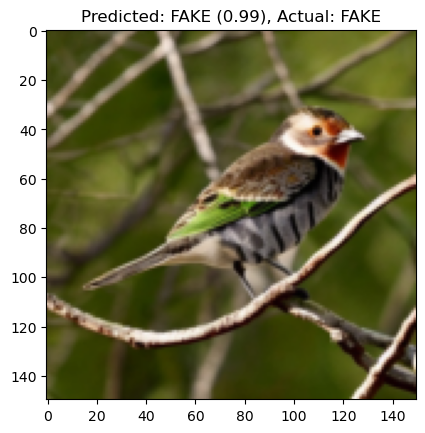

Actual class: FAKE, Predicted class: FAKE, Probability: 0.9911


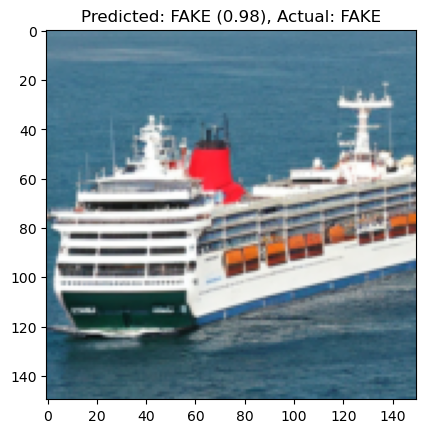

Actual class: FAKE, Predicted class: FAKE, Probability: 0.9829


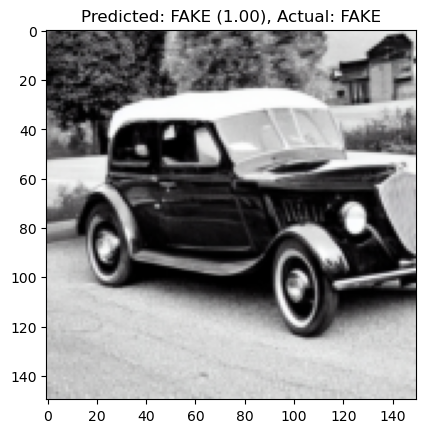

Actual class: FAKE, Predicted class: FAKE, Probability: 0.9999


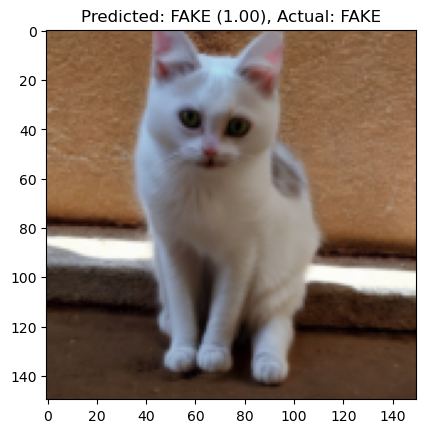

Actual class: FAKE, Predicted class: FAKE, Probability: 1.0000


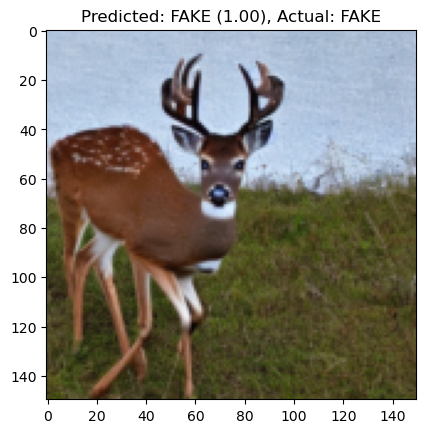

Actual class: FAKE, Predicted class: FAKE, Probability: 0.9998


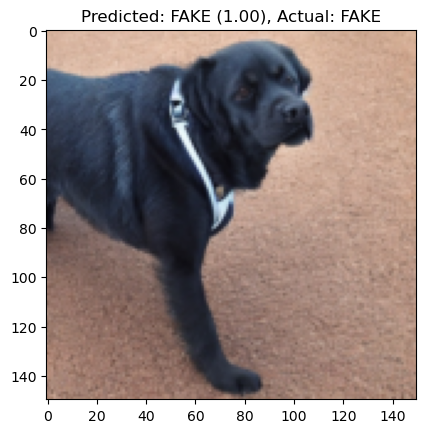

Actual class: FAKE, Predicted class: FAKE, Probability: 0.9996


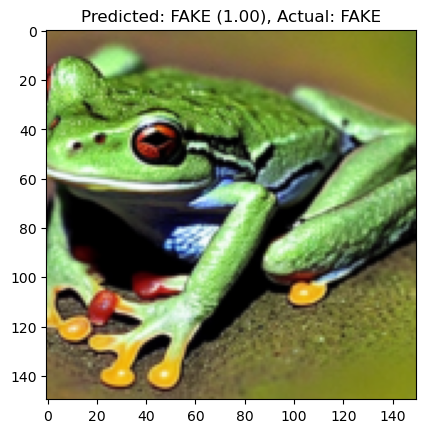

Actual class: FAKE, Predicted class: FAKE, Probability: 0.9999


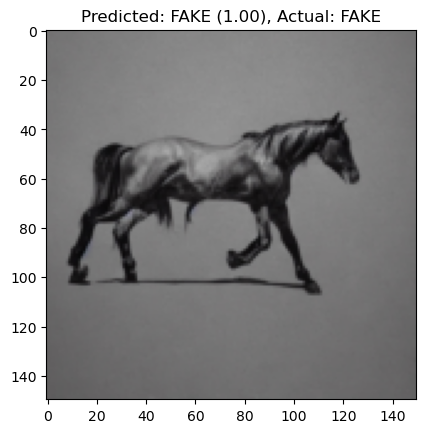

Actual class: FAKE, Predicted class: FAKE, Probability: 0.9995


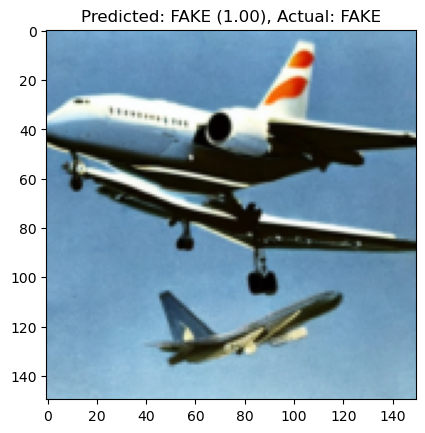

Actual class: FAKE, Predicted class: FAKE, Probability: 0.9998


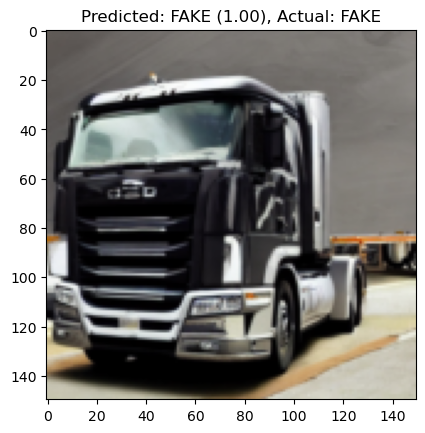

Actual class: FAKE, Predicted class: FAKE, Probability: 0.9989


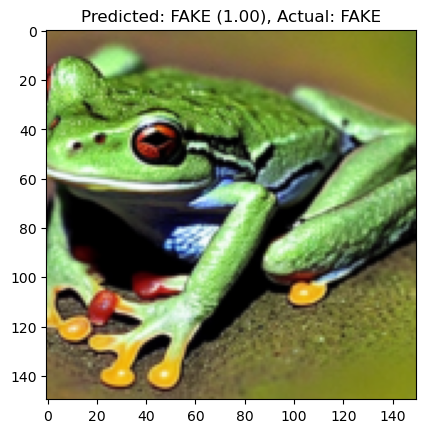

Actual class: FAKE, Predicted class: FAKE, Probability: 0.9999


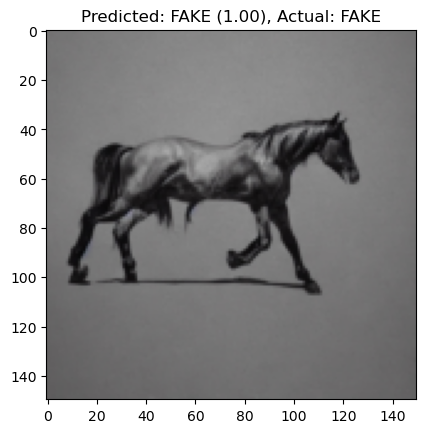

Actual class: FAKE, Predicted class: FAKE, Probability: 0.9995


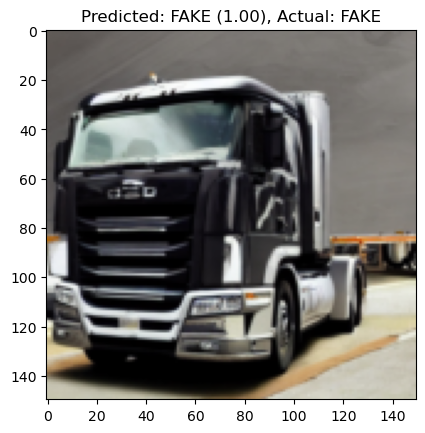

Actual class: FAKE, Predicted class: FAKE, Probability: 0.9989


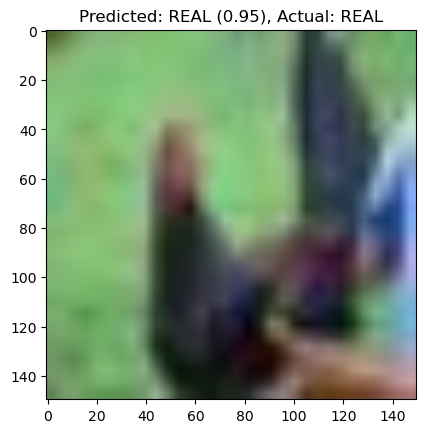

Actual class: REAL, Predicted class: REAL, Probability: 0.9454


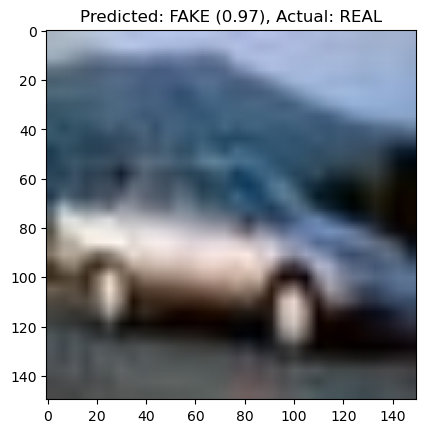

Actual class: REAL, Predicted class: FAKE, Probability: 0.9734


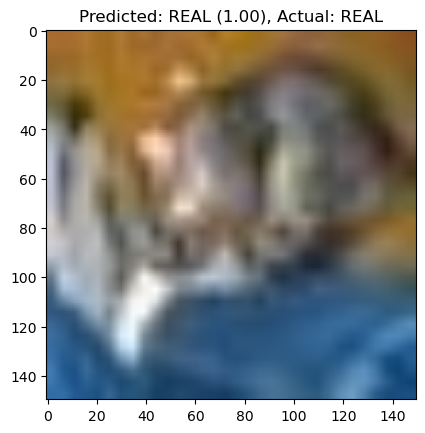

Actual class: REAL, Predicted class: REAL, Probability: 0.9952


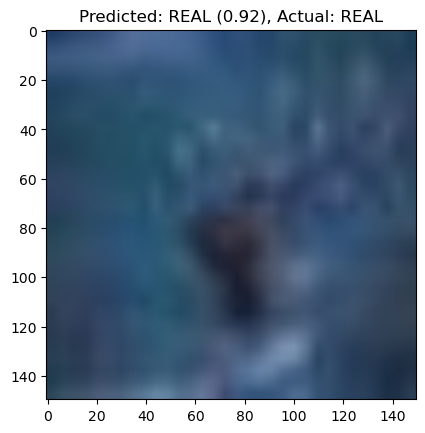

Actual class: REAL, Predicted class: REAL, Probability: 0.9237


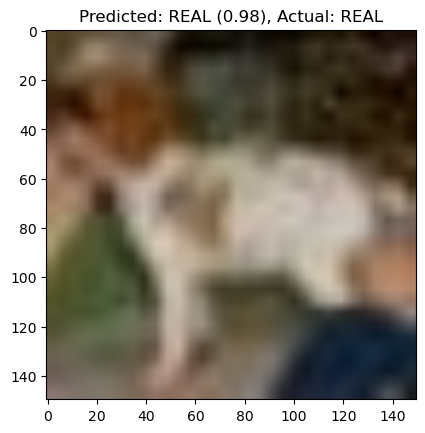

Actual class: REAL, Predicted class: REAL, Probability: 0.9786


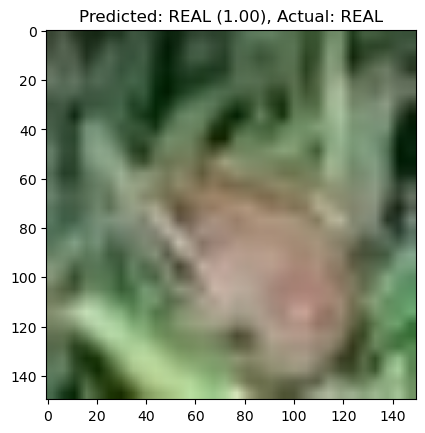

Actual class: REAL, Predicted class: REAL, Probability: 0.9996


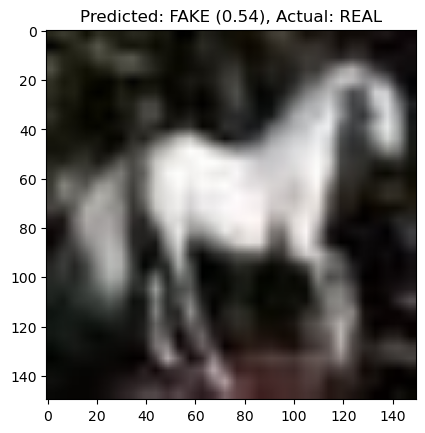

Actual class: REAL, Predicted class: FAKE, Probability: 0.5384


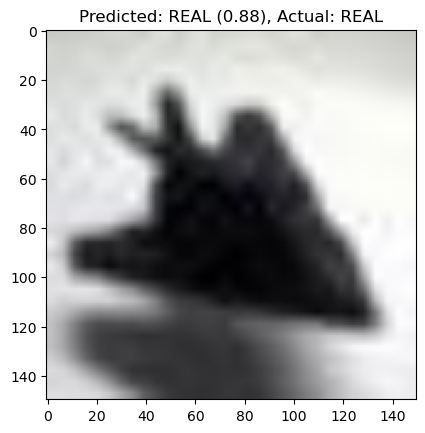

Actual class: REAL, Predicted class: REAL, Probability: 0.8806


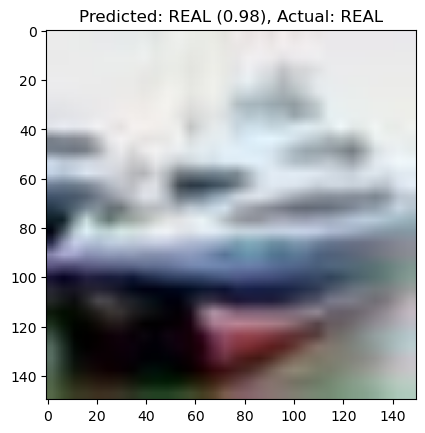

Actual class: REAL, Predicted class: REAL, Probability: 0.9816


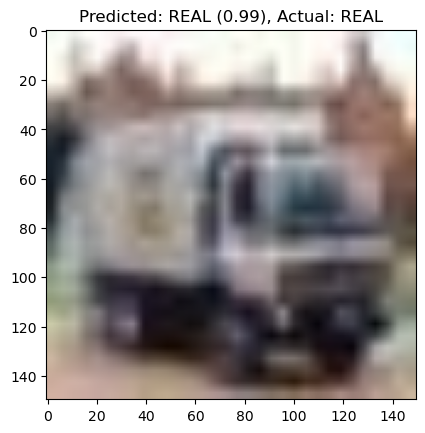

Actual class: REAL, Predicted class: REAL, Probability: 0.9913


In [19]:
from PIL import Image
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Setup device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define transformation
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
])

import shutil

def remove_unwanted_dirs(directory_path):
    unwanted_dir = os.path.join(directory_path, '.ipynb_checkpoints')
    if os.path.exists(unwanted_dir):
        shutil.rmtree(unwanted_dir)

# Call this function for each directory
remove_unwanted_dirs('predict/')

# Load dataset
dataset_path = 'predict/'
dataset = ImageFolder(dataset_path, transform=transform)

# Create DataLoader
data_loader = DataLoader(dataset, batch_size=1, shuffle=False)

# Ensure model is in evaluation mode
model_conv.eval()

# Transform to convert tensors back to PIL Images for visualization
to_pil = transforms.ToPILImage()

# Perform inference and collect results
results = []
with torch.no_grad():
    for images, labels in data_loader:
        images = images.to(device)
        outputs = model_conv(images)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1)
        predicted_probability = probabilities[0][predicted_class].item()

        # Retrieve the class name
        predicted_class_name = dataset.classes[predicted_class.item()]
        actual_class_name = dataset.classes[labels.item()]
        
        # Convert image tensor to PIL image (adjust if the images are not on CPU)
        pil_image = to_pil(images.cpu().squeeze(0))

        # Display the image and its prediction
        plt.imshow(pil_image)
        plt.title(f"Predicted: {predicted_class_name} ({predicted_probability:.2f}), Actual: {actual_class_name}")
        plt.show()

        # Collect the result
        results.append({
            "actual_class": actual_class_name,
            "predicted_class": predicted_class_name,
            "probability": predicted_probability
        })

        # Optionally, print the results for each image
        print(f"Actual class: {actual_class_name}, Predicted class: {predicted_class_name}, Probability: {predicted_probability:.4f}")

# You now have all predictions in 'results', which you can process further
